# CottonWeed15 - MobileNetV3Small

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import shutil

seed = 999
def seedEverything(seed, deterministic = False):
    tf.random.set_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

    tf.keras.utils.set_random_seed(seed)

    if deterministic:
        print("Running Deterministically")
        tf.config.experimental.enable_op_determinism()

        os.environ['TF_DETERMINISTIC_OPS'] = '1'
        os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

        #tf.config.threading.set_inter_op_parallelism_threads(1)
        #tf.config.threading.set_intra_op_parallelism_threads(1)


seedEverything(seed)

2024-05-25 04:11:58.614080: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-25 04:11:58.614163: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-25 04:11:58.750172: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ! pip install kagglehub --upgrade --q

# import kagglehub
# print(kagglehub.__version__)

# from kaggle_secrets import UserSecretsClient
# user_secrets = UserSecretsClient()
# key = user_secrets.get_secret("kaggle_token")

# kagglehub.auth.set_kaggle_credentials('reganmaharjan',key)

In [3]:
## Downloading DeepWeeds Data  ## For Google Colab
# url = 'https://drive.google.com/uc?export=download&id=1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj'
# !gdown 1xnK3B6K6KekDI55vwJ0vnc2IGoDga9cj
# !unzip -qq images.zip -d images

In [4]:
# data_info = pd.read_csv('https://raw.githubusercontent.com/AlexOlsen/DeepWeeds/master/labels/labels.csv') ## for GoogleColab
data_info = pd.read_csv("/kaggle/input/cottonweed15-downsampled/labels.csv") ## For Kaggle
data_info = data_info[['img', 'label']]
data_info

,img,label
0,351b9a52aaaf40f592557cca89a902a5__nutsedge__0.jpg,Nutsedge
1,992b7dca6928459e85aafbf945585dd0__nutsedge__7.jpg,Nutsedge
2,8803be5e86774ff1b7116d5f5a5b2727__nutsedge__0.jpg,Nutsedge
3,e1da7a5e314a41c5886b384bd69320fc__nutsedge__0.jpg,Nutsedge
4,IMG_0547.JPG,Nutsedge
...,...,...
5182,1f101adc29984ee783d36d96ad6e5b7d__purselane__2...,Purslane
5183,0001.jpg,Purslane
5184,IMG_1426.JPG,Purslane
5185,IMG_1481 (3).JPG,Purslane


In [5]:
label_counts = data_info.groupby('label').count()
label_counts.T

label,Carpetweeds,Crabgrass,Eclipta,Goosegrass,Morningglory,Nutsedge,PalmerAmaranth,Prickly Sida,Purslane,Ragweed,Sicklepod,SpottedSpurge,SpurredAnoda,Swinecress,Waterhemp
img,763,111,254,216,1115,273,689,129,450,129,240,234,61,72,451


In [6]:
label2id = data_info['label'].unique()
label2id = {label2id[i]:i for i in range(len(label2id))}
id2label = {label2id[i]:i for i in label2id}
print(id2label)
print(label2id)

{0: 'Nutsedge', 1: 'Sicklepod', 2: 'Morningglory', 3: 'Ragweed', 4: 'PalmerAmaranth', 5: 'Waterhemp', 6: 'Crabgrass', 7: 'Swinecress', 8: 'Prickly Sida', 9: 'Carpetweeds', 10: 'SpottedSpurge', 11: 'SpurredAnoda', 12: 'Eclipta', 13: 'Goosegrass', 14: 'Purslane'}
{'Nutsedge': 0, 'Sicklepod': 1, 'Morningglory': 2, 'Ragweed': 3, 'PalmerAmaranth': 4, 'Waterhemp': 5, 'Crabgrass': 6, 'Swinecress': 7, 'Prickly Sida': 8, 'Carpetweeds': 9, 'SpottedSpurge': 10, 'SpurredAnoda': 11, 'Eclipta': 12, 'Goosegrass': 13, 'Purslane': 14}


In [7]:
data_info['img'] = data_info.apply(lambda x: str(label2id[x['label']])+"_"+x['img'], axis=1)

In [8]:
threshold = label_counts.quantile(0.25).iloc[0]
print(threshold)

low_data_labels = label_counts[label_counts['img'] <= threshold] ## labels with very low data
print(low_data_labels.T)
low_data_labels = list(low_data_labels.T.keys())
low_data_labels

129.0
label  Crabgrass  Prickly Sida  Ragweed  SpurredAnoda  Swinecress
img          111           129      129            61          72


['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']

## Splitting Data into Train:Valid:Test Splits (60:40:40)

In [9]:
# colabAI prompt: train test split using data_info
from sklearn.model_selection import train_test_split, StratifiedKFold

### K-Fold Validation-----
#####---------------------
split_index = 1 # index to retrieve
print("Using KFold: Index",split_index+1,"out of 5 folds")
print("-------------------------------------------------\n")

skfold = StratifiedKFold(shuffle=True, random_state=seed)
kSplits = skfold.split(data_info['img'], y=data_info['label'])

for index in range(skfold.get_n_splits()):
    train_index, test_index = next(kSplits)
    if index == split_index:
        break

# trax, tex, tray, tey = train_test_split(data_info['Filename'],data_info['Label'], test_size=0.4, random_state=seed)
# train_data = pd.DataFrame({"Filename":trax,"label":tray})

# trax, tex, tray, tey = train_test_split(tex,tey, test_size=0.5, random_state=seed)
# valid_data = pd.DataFrame({"Filename":trax,"label":tray})
# test_data = pd.DataFrame({"Filename":tex,"label":tey})

Using KFold: Index 2 out of 5 folds
-------------------------------------------------



In [10]:
train_data = data_info.iloc[train_index]
test_data = data_info.iloc[test_index]

print("Is There Duplicates: ", not test_data[test_data['img'].isin(train_data['img'])].empty)
print("Train Data\n-----------------------\n",train_data.groupby(by='label').count().T, "\tTotal:", train_data.shape)
print("||\nTest Data\n-------------------------\n",test_data.groupby(by='label').count().T, "\tTotal:", test_data.shape)

Is There Duplicates:  False
Train Data
-----------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            610         89      204         172           892       218   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               552           103       360      103        192   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img              188            48          58        360   	Total: (4149, 2)
||
Test Data
-------------------------
 label  Carpetweeds  Crabgrass  Eclipta  Goosegrass  Morningglory  Nutsedge  \
img            153         22       50          44           223        55   

label  PalmerAmaranth  Prickly Sida  Purslane  Ragweed  Sicklepod  \
img               137            26        90       26         48   

label  SpottedSpurge  SpurredAnoda  Swinecress  Waterhemp  
img               46            13          14         91   	Total: (1038, 2)


## Helper Functions

- Organize Images to Directory as per Label for Creating Generator (organize_data_to_directory)
- Dataset Generator (getDatasetGenerators) - works in tandem with "organize_data_to_directory"
- Class Weights For Imbalanced Dataset (getWeightedClass)
- Accuracy / Loss plot (plot_loss_acc)
- Evaluation Metrics Calculation (eval_model, print_stats, calcFalseRate)
- Prediction with Threshold as used by DeepWeeds Author (prediction_argmax)



In [11]:
from tqdm.auto import tqdm

def organize_data_to_directory(data_info,source_dir='',target_dir='',oversample=0,oversampling_labels=[]):
    for index, row in tqdm(data_info.iterrows()):
        filename = row['img']
        label = row['label']

        source = os.path.join(source_dir,filename)

        #if not os.path.exists(source):
        #    print("File Doesn't Exist", source)
        #    continue

        target_path = os.path.join(target_dir,str(label))
        target = os.path.join(target_path,filename)
        # print(source,target)

        if not os.path.exists(target_path):
            os.mkdir(target_path)

        if not os.path.exists(target):
            if oversample and (label in oversampling_labels):
                for i in range(oversample):
                    sample_filename = os.path.join(target_path, "oversample-"+str(i)+"-"+filename)
                    shutil.copy(source, sample_filename)

            shutil.copy(source,target)

##-----------------------------
###----------------------------

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import image_dataset_from_directory

def getDatasetGenerators(train_dir, **kwargs):
    # --------------------
    # Flow training images in batches using generator
    # --------------------
    generator = image_dataset_from_directory(
        train_dir,
        **kwargs
    )

    return generator

In [12]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

def prediction_argmax(prediction, rand_guess=1):
    l_pred = np.argmax(prediction[low_data_labels])
    if(prediction[l_pred] > rand_guess):
        return l_pred

    return np.argmax(prediction)

def calcFalsePositiveRate(a_label, p_label, label_names=None, n_class=None):
    if n_class is None:
        n_class = len(np.unique(a_label))
    conf_mat = tf.math.confusion_matrix(a_label, p_label, num_classes=n_class).numpy()

    false_rate = []
    total = len(a_label)
    for i in range(n_class):
        tP = conf_mat[i][i]
        fN = np.sum(conf_mat[i,:]) - tP

        fP = np.sum(conf_mat[:,i]) - tP
        tN = total - (tP + fN + fP)

        fP_Rate = fP/(tN+fP)
        # fN_Rate = fN/(tP+fN)
        accuracy = tP / (tP+fN)

        false_rate.append((fP_Rate,accuracy))

    false_rate = pd.DataFrame(false_rate, columns=["False Positive Rate", "Accuracy"], index=label_names)
    return false_rate

def printStats(actual_labels,prediction, use_rand_guess= 0):
    if use_rand_guess:
        prediction = [prediction_argmax(x, rand_guess=use_rand_guess) for x in prediction]
    else:
        prediction = [np.argmax(x) for x in prediction]

    print("Evaluation Metrics\n=================================\n")
    #     print("F1-Score",f1_score(actual_labels,prediction,average='weighted'))
    #     print("Precision-Score",precision_score(actual_labels,prediction,average='weighted'))
    #     print("Recall-Score",recall_score(actual_labels,prediction,average='weighted'))
    #     print("accuracy_Score",accuracy_score(actual_labels,prediction))

    label_names = [id2label[i] for i in range(len(id2label))]
    print(classification_report(actual_labels, prediction,digits=5, target_names=label_names))
    print()
    print(calcFalsePositiveRate(actual_labels, prediction, label_names = label_names))
    print()
    print("Confusion Matrix\n=================================\n")
    n_class = np.unique(actual_labels).shape[0]

    cmd = ConfusionMatrixDisplay.from_predictions(
        actual_labels, prediction,
        display_labels=label_names,
        xticks_rotation=80, #'vertical',
        # ax = ax
    )
    # fig, ax = plt.subplots(figsize=(25,5))
    # cmd.plot(ax=ax)
    plt.show()

def eval_model(model, data_gen, use_rand_guess=False):
    print("model.evaluate")
    model.evaluate(data_gen)

    print("model.predict")
    actual_labels = []
    pred_prob = []
    for batch in tqdm(data_gen):
        actual_labels.extend([np.argmax(z) for z in batch[1]])
        pred_prob.extend(list(model.predict_on_batch(batch[0])))

    printStats(actual_labels,pred_prob,use_rand_guess)
    return actual_labels, pred_prob


def plot_loss_acc(history):
    '''Plots the training and validation loss and accuracy from a history object'''
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    if 'peaks' in history:
        peaks = history['peaks']
    else:
        _min = np.argmin(val_loss)
        peaks = [_min]

    epochs = range(len(acc))
    print("Total Epochs:",epochs)

    plt.figure(figsize=[16, 4])
    plt.subplot(1,2,1)
    p_value = [val_acc[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, acc, label='Training accuracy', color='red')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='magenta')
    plt.title('Training and validation accuracy')
    plt.legend()

    plt.subplot(1,2,2)
    p_value = [val_loss[p] for p in peaks]
    plt.scatter(peaks, p_value, marker='o',s=50)
    plt.plot(epochs, loss, label='Training Loss', color='red')
    plt.plot(epochs, val_loss, label='Validation Loss', color='magenta')
    plt.title('Training and validation loss')
    plt.legend()

    plt.show()

## Creating Dateset ImageGenerator

In [13]:
IMG_SIZE=(256,256,3)
oversampling = 2 # How many times are we gonna over sample

if oversampling:
    print("Oversampling",oversampling,"times for labels",low_data_labels)
else:
    print("No OverSampling")

# base_dir = '/content/dataset_9c' ## For GoogleColab
# input_dir = '/content/images' ## For GoogleColab

input_dir = "/kaggle/input/cottonweed15-downsampled/img" ## For Kaggle
base_dir = "/kaggle/working/cottonweed15" ## For Kaggle

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

os.mkdir(base_dir)
os.mkdir(train_dir)
os.mkdir(test_dir)

## Organizing Training Data
organize_data_to_directory(train_data, source_dir=input_dir, target_dir=train_dir, oversample=oversampling, oversampling_labels=low_data_labels)

# ## Organizing Test Data
organize_data_to_directory(test_data, source_dir=input_dir, target_dir=test_dir)

Oversampling 2 times for labels ['Crabgrass', 'Prickly Sida', 'Ragweed', 'SpurredAnoda', 'Swinecress']


0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [14]:
train_generator, validation_generator = getDatasetGenerators(
      train_dir,
      batch_size=32,
      label_mode='categorical',
      class_names=label2id.keys(),
      image_size = IMG_SIZE[:2],
      shuffle=True,
      seed=seed,
      validation_split=0.25,
      subset="both"
)

test_generator = getDatasetGenerators(
      test_dir,
      batch_size=16,
      label_mode='categorical',
      class_names=label2id.keys(),
      image_size = IMG_SIZE[:2],
      shuffle=False
)

Found 4951 files belonging to 15 classes.
Using 3714 files for training.
Using 1237 files for validation.
Found 1038 files belonging to 15 classes.


### Displaying Images

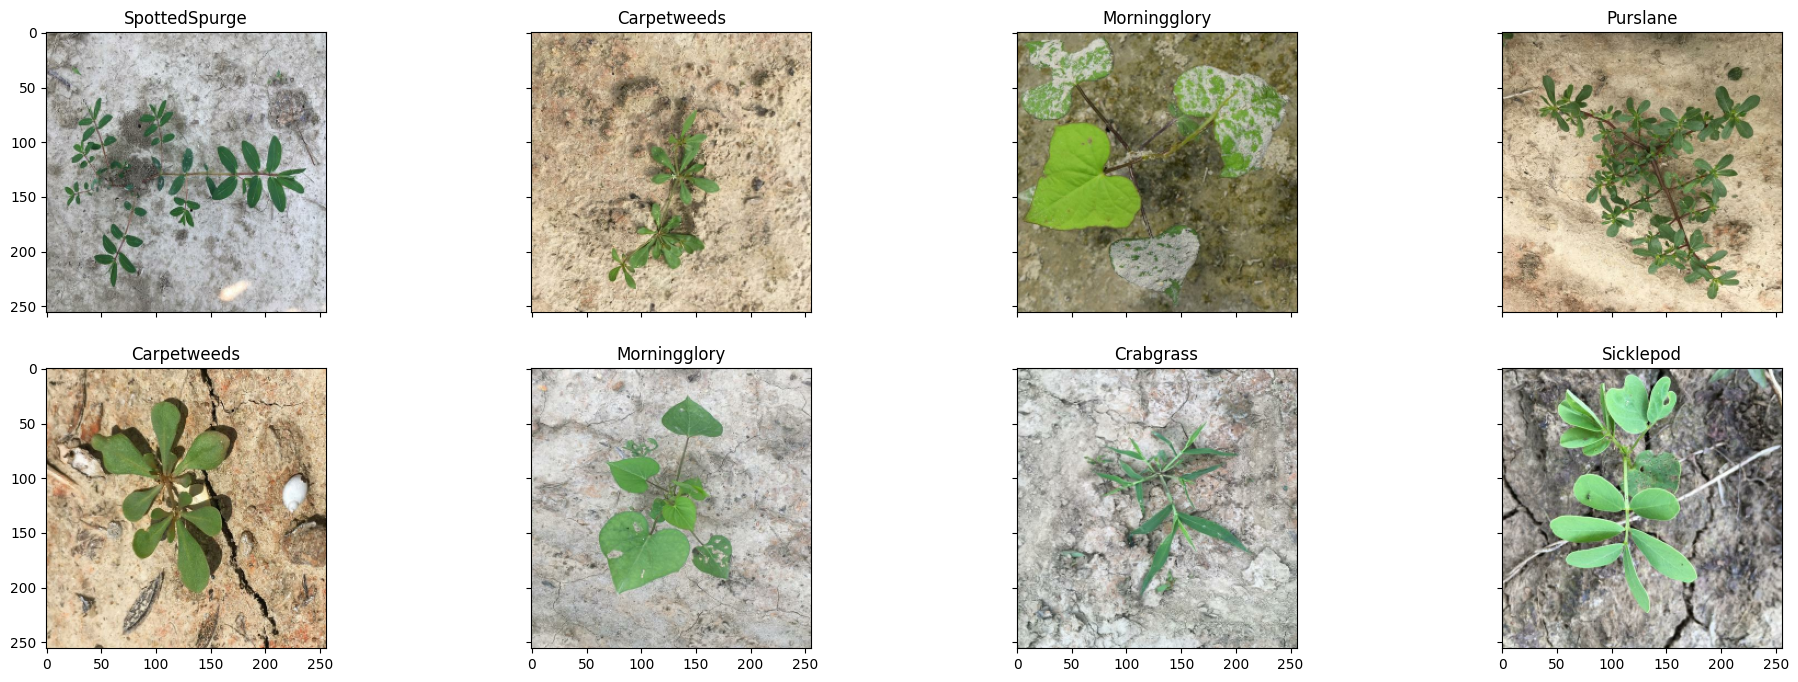

In [15]:
#image visualization
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(24,8))

for images, labels in validation_generator:
    for i in range(2):
        for j in range(4):
            ax[i][j].imshow(images[i+j*2].numpy().astype(np.int32))
            ax[i][j].set_title(id2label[np.argmax(labels[i+j*2])])

    break
plt.show()

# Pooling Schemes

In [16]:
import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalMaxPooling2D, MaxPool2D, Reshape, \
                        Dense, multiply, Permute, Concatenate, Conv2D, Add, Activation, Lambda, Average
from tensorflow.keras import backend as K
from tensorflow.keras.activations import sigmoid, softmax

class SpatialMaxPooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialMaxPooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.max = tf.keras.layers.MaxPool1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.max(x)
        x = self.reshape_backward(x)
        return x

class SpatialAveragePooling2D(tf.keras.layers.Layer):
    def __init__(self,pool_size=2,stride=None,padding='valid',data_format='channels_last', **kwargs):
        super(SpatialAveragePooling2D,self).__init__(**kwargs)
        self.pool_size = pool_size
        self.stride = stride
        self.padding = padding
        if stride is None:
            self.stride = self.pool_size

        self.data_format = 'channels_last' if data_format == 'channels_first' else 'channels_first'
        self.avg = tf.keras.layers.AveragePooling1D(self.pool_size, self.stride, padding=self.padding, data_format=self.data_format)

    def build(self,input_shape):
        self.reshape_forward = tf.keras.layers.Reshape((-1,input_shape[-1]))
        self.reshape_backward= tf.keras.layers.Reshape((input_shape[1], input_shape[2], -1))

    def call(self,x):
        x = self.reshape_forward(x)
        x = self.avg(x)
        x = self.reshape_backward(x)
        return x

def AverageOfMaximums(x, max_pool_size=2, layer_num=1):
    _max = layers.MaxPooling2D(pool_size=max_pool_size,padding='same', name="Maximums_L{}".format(layer_num))(x)
    _avg = layers.GlobalAveragePooling2D(name="Average_of_Maximums_L{}".format(layer_num))(_max)
    return _avg

# Transformer Encoder: Global Self Attention & Point-wise Feed Forward

In [17]:
class BaseAttention(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()


class GlobalSelfAttention(BaseAttention):
    def call(self, x):
        attn_output = self.mha(
            query=x,
            value=x,
            key=x)
        x = self.add([x, attn_output])
        x = self.layernorm(x)
        return x

class FeedForward(tf.keras.layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.1):
        super().__init__()
        self.seq = tf.keras.Sequential([
          tf.keras.layers.Dense(dff, activation='relu'),
          tf.keras.layers.Dense(d_model),
          tf.keras.layers.Dropout(dropout_rate)
        ])
        self.add = tf.keras.layers.Add()
        self.layer_norm = tf.keras.layers.LayerNormalization()

    def call(self, x):
        x = self.add([x, self.seq(x)])
        x = self.layer_norm(x)
        return x

# Building MobileNet Model

In [18]:
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large

def augment(seed=42):
    return keras.Sequential([
        layers.RandomBrightness(0.2, (0, 1),seed=seed, name='RR_Bright'),
        # layers.RandomContrast(0.2, seed=seed, name='RR_Contr'), # can't run deterministically
        layers.RandomFlip(seed=seed, name='RR_Flip'),
        layers.RandomRotation(0.5, seed=seed, name='RR_Rot'),
        layers.RandomTranslation(0.3, 0.3, seed=seed, name='RR_Trans'),
        layers.RandomZoom(0.1, 0.1, seed=seed, name='RR_Zoom'),
        layers.GaussianDropout(0.01, seed=seed, name='RR_Gauss'),
    ], name='augment_pipeline')


def skipAugment(model):
    inputs = keras.Input(shape=IMG_SIZE)
    x = inputs
    for layer in model.layers:
        if 'augment' not in layer.name and 'input' not in layer.name:
            x = layer(x)

    model = keras.Model(inputs=inputs, outputs=x, name=model.name)
    return model


def buildModel(train=False):
    # Load the MobileNet model with weights pre-trained on ImageNet.
    base_model = MobileNetV3Small(input_shape=(224,224,3), weights='imagenet', include_top=False)
    base_model.trainable = train

    print("Base Model:", base_model.name)

    # Define the input layer.
    inputs = keras.Input(shape=IMG_SIZE, name='input')

    # Pre-process the input.
    x = layers.Rescaling(1./255, name='PP_Rescale')(inputs)
    x = layers.Resizing(224, 224, name='PP_Resize')(x)

    x = augment(seed)(x)
    # Pass the input through the pre-trained InceptionV3 model.
    x = base_model(x, training=train)

    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dropout(0.3)(x)

    outputs = layers.Dense(15, activation='softmax')(x)

    model_name = "CottonWeed15-" + base_model.name.upper()
    # Create the model.
    model = keras.Model(inputs=inputs, outputs=outputs, name=model_name)
    return model

In [19]:
# IMG_SIZE = (256,256,3)
# seed = 42

model = buildModel(True)
model.summary()

4334752/4334752 [==============================] - 0s 0us/step
Base Model: MobilenetV3small
Model: "CottonWeed15-MOBILENETV3SMALL"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 256, 3)]     0         
                                                                 
 PP_Rescale (Rescaling)      (None, 256, 256, 3)       0         
                                                                 
 PP_Resize (Resizing)        (None, 224, 224, 3)       0         
                                                                 
 augment_pipeline (Sequenti  (None, 224, 224, 3)       0         
 al)                                                             
                                                                 
 MobilenetV3small (Function  (None, 7, 7, 576)         939120    
 al)                                                             
           

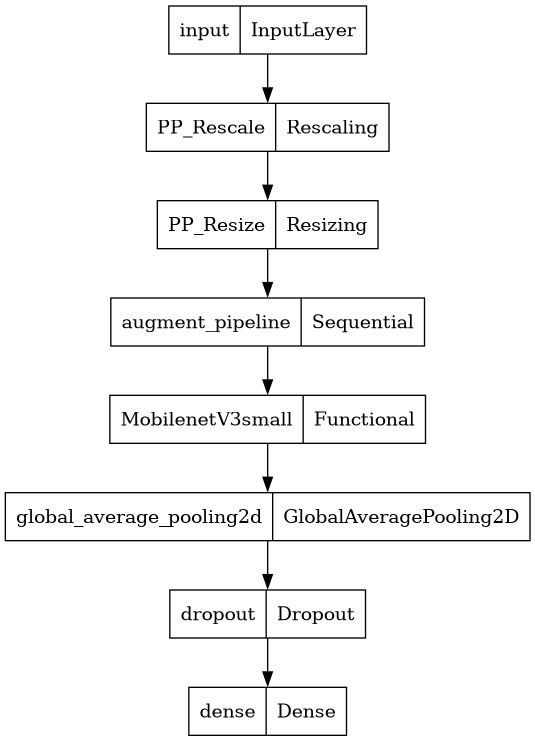

In [20]:
keras.utils.plot_model(model)

## Trial 1 - FineTuning

In [21]:
from tensorflow.keras.optimizers import RMSprop, AdamW

# Constant for epochs
EPOCHS = 100

pat_es = 10
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=pat_es, verbose=1, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-6)

model.compile(loss='categorical_crossentropy',
          optimizer=AdamW(learning_rate=1e-4,  weight_decay=5e-2),
          metrics=['accuracy'])
# weights = getWeightedClass(data_info, 1/3)
# weights

Epoch 1/100


I0000 00:00:1716610378.617328     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


117/117 [==============================] - 43s 100ms/step - loss: 2.5525 - accuracy: 0.2019 - val_loss: 2.0668 - val_accuracy: 0.3355 - lr: 1.0000e-04
Epoch 2/100
117/117 [==============================] - 10s 81ms/step - loss: 2.0279 - accuracy: 0.3546 - val_loss: 1.5973 - val_accuracy: 0.5036 - lr: 1.0000e-04
Epoch 3/100
117/117 [==============================] - 8s 69ms/step - loss: 1.6003 - accuracy: 0.4898 - val_loss: 1.2375 - val_accuracy: 0.6209 - lr: 1.0000e-04
Epoch 4/100
117/117 [==============================] - 9s 72ms/step - loss: 1.3303 - accuracy: 0.5692 - val_loss: 0.9971 - val_accuracy: 0.7017 - lr: 1.0000e-04
Epoch 5/100
117/117 [==============================] - 9s 71ms/step - loss: 1.1027 - accuracy: 0.6473 - val_loss: 0.8256 - val_accuracy: 0.7486 - lr: 1.0000e-04
Epoch 6/100
117/117 [==============================] - 9s 72ms/step - loss: 0.9352 - accuracy: 0.7014 - val_loss: 0.6997 - val_accuracy: 0.7833 - lr: 1.0000e-04
Epoch 7/100
117/117 [======================

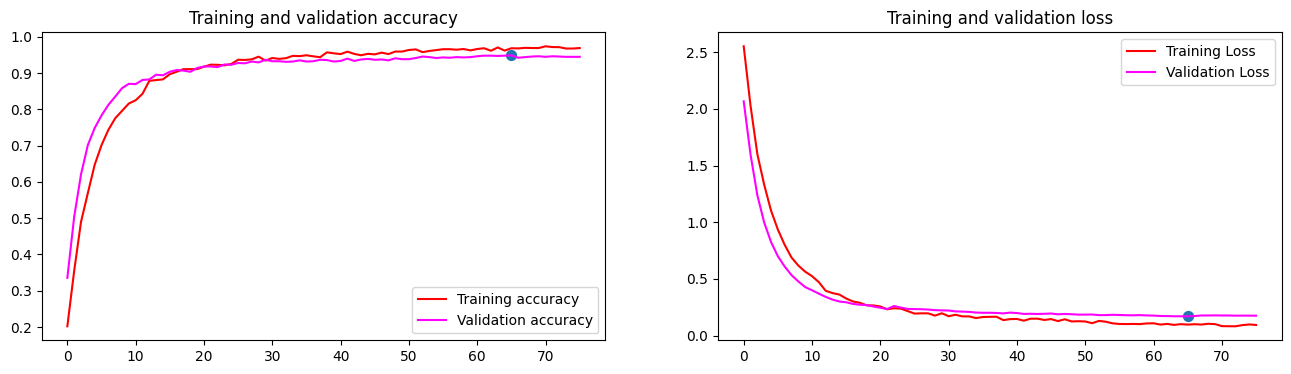

CPU times: user 29min 32s, sys: 1min 32s, total: 31min 4s
Wall time: 11min 32s


In [22]:
%%time

# Train the model
history1 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr],
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history1.history)

model.evaluate
39/39 [==============================] - 1s 37ms/step - loss: 0.1699 - accuracy: 0.9491
model.predict


  0%|          | 0/39 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.94915   1.00000   0.97391        56
     Sicklepod    1.00000   0.93750   0.96774        48
  Morningglory    0.96460   0.96889   0.96674       225
       Ragweed    0.94048   0.98750   0.96341        80
PalmerAmaranth    0.93662   0.92361   0.93007       144
     Waterhemp    0.86813   0.88764   0.87778        89
     Crabgrass    0.98413   1.00000   0.99200        62
    Swinecress    1.00000   1.00000   1.00000        40
  Prickly Sida    0.97468   0.95062   0.96250        81
   Carpetweeds    0.98148   0.95783   0.96951       166
 SpottedSpurge    0.90909   0.95238   0.93023        42
  SpurredAnoda    0.86667   0.96296   0.91228        27
       Eclipta    0.93023   0.78431   0.85106        51
    Goosegrass    0.94872   0.94872   0.94872        39
      Purslane    0.92222   0.95402   0.93785        87

      accuracy                        0.94907      1237
     macro avg    0.94508 

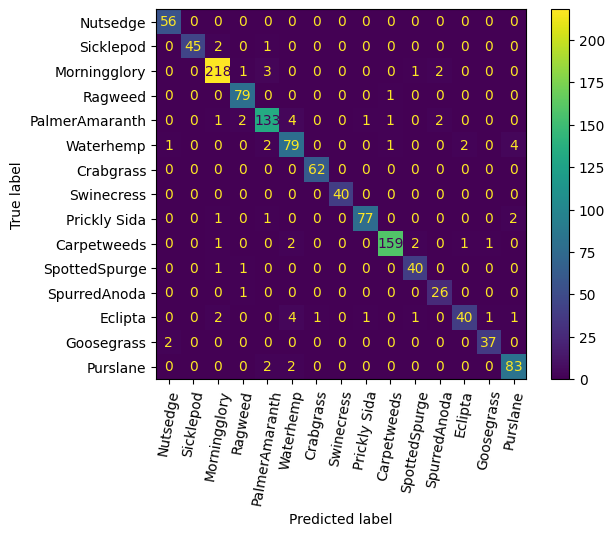

In [23]:
a, b = eval_model(model, validation_generator)

# Trial 2 - Freezing Base Model

Freezing Layer MobilenetV3small
Epoch 1/100
117/117 [==============================] - 11s 57ms/step - loss: 1.0047 - accuracy: 0.7173 - val_loss: 0.6287 - val_accuracy: 0.8205 - lr: 1.0000e-06
Epoch 2/100
117/117 [==============================] - 7s 58ms/step - loss: 0.9840 - accuracy: 0.7294 - val_loss: 0.6255 - val_accuracy: 0.8213 - lr: 1.0000e-06
Epoch 3/100
117/117 [==============================] - 6s 47ms/step - loss: 0.9909 - accuracy: 0.7270 - val_loss: 0.6224 - val_accuracy: 0.8213 - lr: 1.0000e-06
Epoch 4/100
117/117 [==============================] - 6s 47ms/step - loss: 0.9676 - accuracy: 0.7289 - val_loss: 0.6195 - val_accuracy: 0.8222 - lr: 1.0000e-06
Epoch 5/100
117/117 [==============================] - 6s 47ms/step - loss: 0.9785 - accuracy: 0.7141 - val_loss: 0.6164 - val_accuracy: 0.8222 - lr: 1.0000e-06
Epoch 6/100
117/117 [==============================] - 6s 46ms/step - loss: 0.9686 - accuracy: 0.7229 - val_loss: 0.6134 - val_accuracy: 0.8238 - lr: 1.0000e-06
E

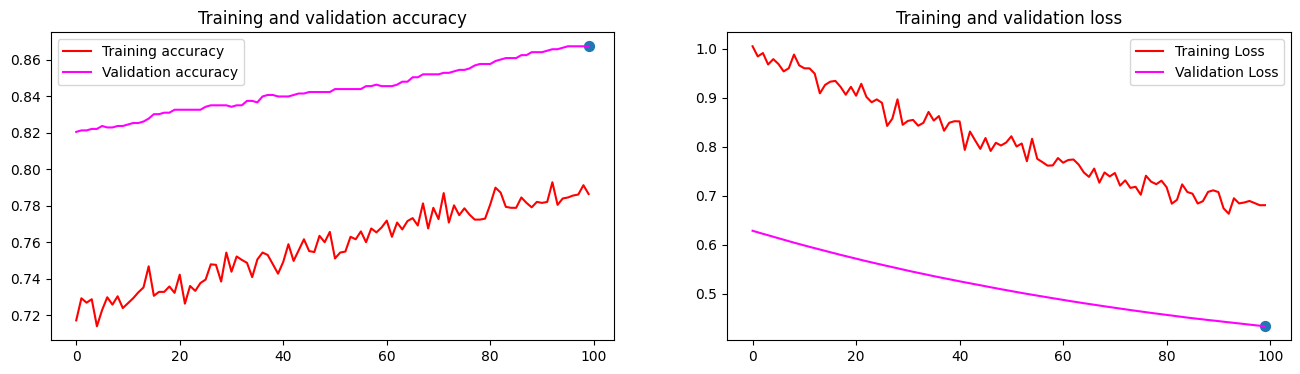

CPU times: user 31min 25s, sys: 1min 39s, total: 33min 5s
Wall time: 9min 58s


In [24]:
%%time
# weights = getWeightedClass(data_info, 1/2)
# print("Using Class-Weights",weights)
# model = skipAugment(model)
for layer in model.layers:
    if('mobilenet' in layer.name.lower()):
        print("Freezing Layer", layer.name)
        layer.trainable = False
        break

model.compile(loss='categorical_crossentropy',
  optimizer=AdamW(learning_rate=1e-6,  weight_decay=2e-4),
  metrics=['accuracy'])

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',factor=0.5, patience=3, verbose=1, min_lr=1e-8)
# Train the model
history2 = model.fit(
      train_generator,
      epochs=EPOCHS,
      validation_data=validation_generator,
      callbacks=[early_stopping, reduce_lr]
    )

print("Saving the Model")
model.save(model.name+".keras")

# Plot training results
plot_loss_acc(history2.history)

## Evaluations

Total Epochs: range(0, 176)


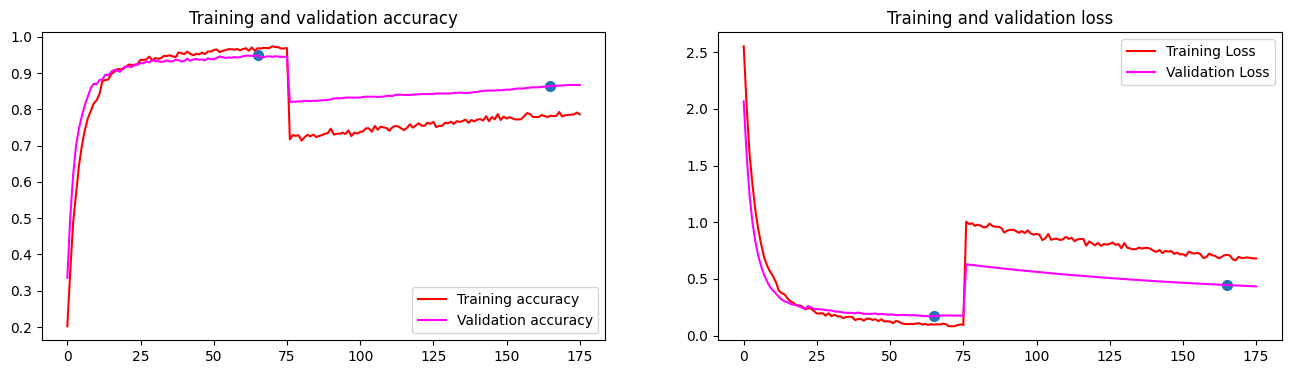

In [25]:
import copy

history = copy.deepcopy(history1.history)

for key in history:
    history[key].extend(history2.history[key])


h1len = len(history1.history['accuracy'])
h2len = len(history2.history['accuracy'])

pat_es +=1
history['peaks'] = [h1len-pat_es, (h1len+h2len)-pat_es]
history['peaks'] = [i if i>=0 else 0 for i in history['peaks']]

plot_loss_acc(history)

Total Epochs: range(0, 76)


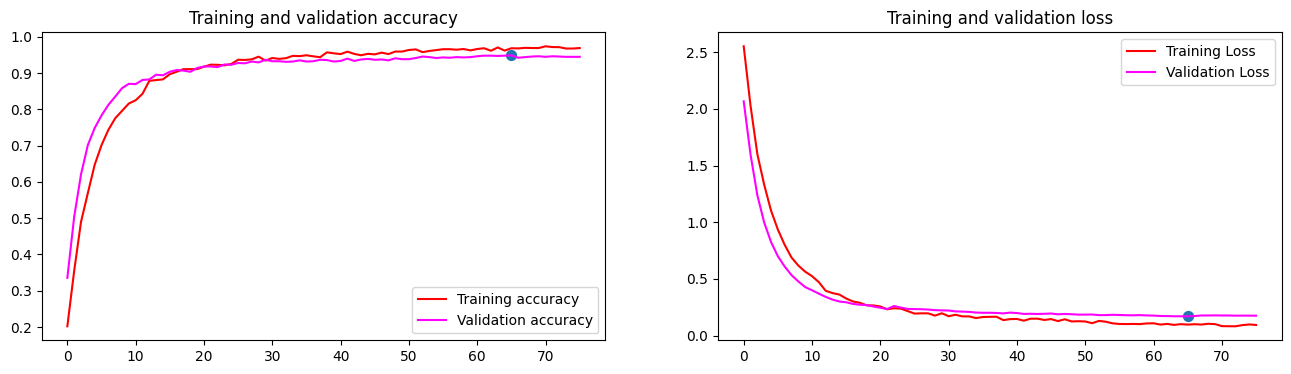

Total Epochs: range(0, 100)


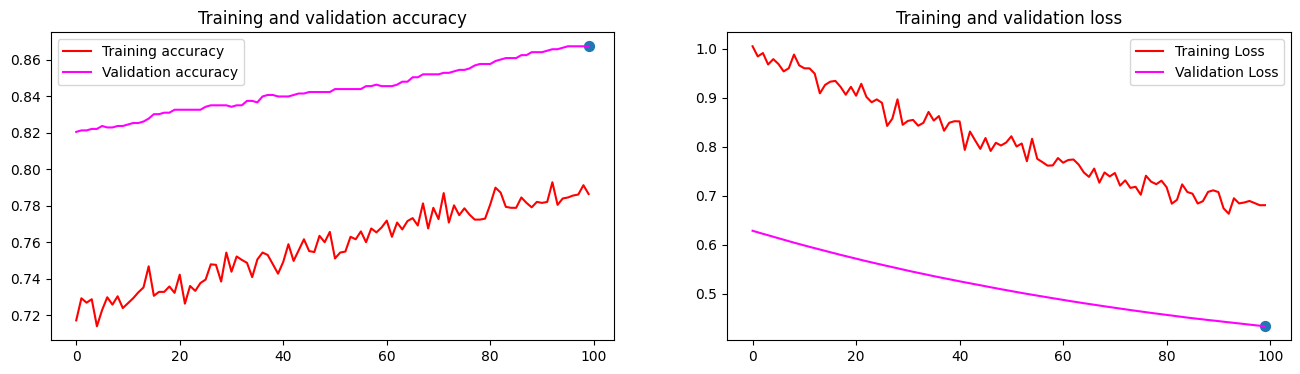

In [26]:
plot_loss_acc(history1.history)
plot_loss_acc(history2.history)

model.evaluate
39/39 [==============================] - 1s 35ms/step - loss: 0.4339 - accuracy: 0.8674
model.predict


  0%|          | 0/39 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.90000   0.96429   0.93103        56
     Sicklepod    0.76364   0.87500   0.81553        48
  Morningglory    0.89912   0.91111   0.90508       225
       Ragweed    0.91250   0.91250   0.91250        80
PalmerAmaranth    0.82237   0.86806   0.84459       144
     Waterhemp    0.93939   0.69663   0.80000        89
     Crabgrass    0.96875   1.00000   0.98413        62
    Swinecress    1.00000   0.80000   0.88889        40
  Prickly Sida    1.00000   0.58025   0.73438        81
   Carpetweeds    0.90173   0.93976   0.92035       166
 SpottedSpurge    0.80851   0.90476   0.85393        42
  SpurredAnoda    0.83871   0.96296   0.89655        27
       Eclipta    0.84211   0.62745   0.71910        51
    Goosegrass    0.91892   0.87179   0.89474        39
      Purslane    0.66929   0.97701   0.79439        87

      accuracy                        0.86742      1237
     macro avg    0.87900 

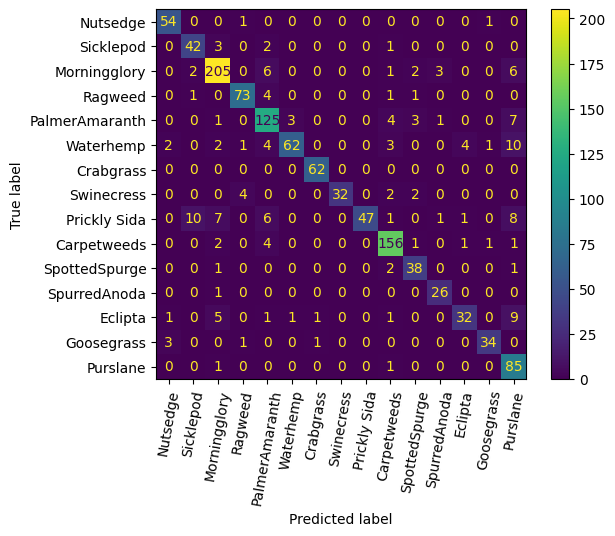

In [27]:
## Computing Positive Threshold Using Validation Dataset
a, b = eval_model(model,validation_generator)

### Normal Evaluation

Normal Evaluation   
--------------------------------------------------------------------
model.evaluate
65/65 [==============================] - 3s 29ms/step - loss: 0.4282 - accuracy: 0.8555
model.predict


  0%|          | 0/65 [00:00<?, ?it/s]

Evaluation Metrics

                precision    recall  f1-score   support

      Nutsedge    0.88333   0.96364   0.92174        55
     Sicklepod    0.85000   0.70833   0.77273        48
  Morningglory    0.87946   0.88341   0.88143       223
       Ragweed    0.88889   0.92308   0.90566        26
PalmerAmaranth    0.88652   0.91241   0.89928       137
     Waterhemp    0.92958   0.72527   0.81481        91
     Crabgrass    0.88000   1.00000   0.93617        22
    Swinecress    0.85714   0.85714   0.85714        14
  Prickly Sida    0.69231   0.34615   0.46154        26
   Carpetweeds    0.88344   0.94118   0.91139       153
 SpottedSpurge    0.91111   0.89130   0.90110        46
  SpurredAnoda    0.52381   0.84615   0.64706        13
       Eclipta    0.93939   0.62000   0.74699        50
    Goosegrass    0.90244   0.84091   0.87059        44
      Purslane    0.68333   0.91111   0.78095        90

      accuracy                        0.85549      1038
     macro avg    0.83938 

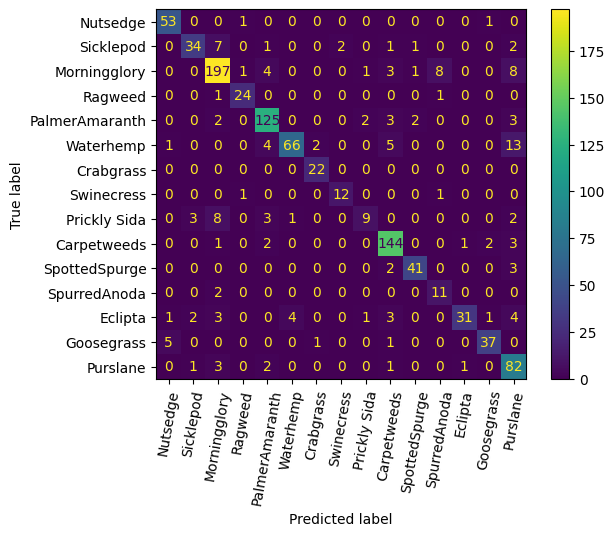

In [28]:
print("Normal Evaluation \
  \n--------------------------------------------------------------------")
a, b = eval_model(model, test_generator)

In [ ]:
shutil.rmtree(base_dir)